In [1]:
import keras
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pandas as pd
import pickle
import elf
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [17]:
baseline = 'revPBE'
reference = 'PBE_dz'
# systems = ['dimers','trimers','128']
# systems = ['monomers','dimers','trimers','64']
# systems = ['monomers','dimers','trimers']
# systems = ['hexamers_embedded_ghost']
# systems = ['monomers','dimers','trimers','hexamers_embedded_ghost']
systems = ['64']
which = 'o'
all_targets = []
all_features = []
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_default_elf/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' +baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' +reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    if 'hexamers_embedded' in system:
        feat = np.concatenate([feat[::12],feat[1::12]])
        targets = np.concatenate([targets[::12],targets[1::12]])
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


In [18]:
nan = np.unique(np.where(np.isnan(feat))[0])
not_nan = np.delete(np.arange(len(feat)),nan, axis=0)
feat = feat[not_nan]
targets = targets[not_nan]

In [19]:
feat_mask = (np.std(feat, axis =0) > 1e-3)
feat = feat[:, feat_mask]

tar = targets
percentile_cutoff = 0.01
selection = []
for t in tar.T:
    lim1 = np.percentile(t, percentile_cutoff*100)
    lim2 = np.percentile(t, (1 - percentile_cutoff)*100)
    min_lim, max_lim = min(lim1,lim2), max(lim1,lim2)
    selection.append((t > min_lim) & (t < max_lim))

filt = [s1 & s2 & s3 for s1,s2,s3 in zip(*selection)]


feat = feat[filt]
tar = tar[filt]
print(feat.shape)

# scaler = Normalizer()
# scaler.fit(feat)
# feat = scaler.transform(feat)

# pca = PCA(n_components=36)
# feat = pca.fit_transform(feat)

scaler = MinMaxScaler()
scaler.fit(feat)
feat = scaler.transform(feat)
#     feat = mono_feat
#     tar = mono_targets
#     feat = np.concatenate([mono_feat,dimer_feat], axis = 0)
#     tar = np.concatenate([mono_targets,dimer_targets], axis = 0)
# X_train, X_test, y_train, y_test = train_test_split(feat, 
#                                                     tar,
#                                                     shuffle =True, random_state = 42, test_size = 0.4) 


(2712, 15)


In [20]:
filt_o = np.array(filt)

In [21]:
filt_h = np.array(filt)

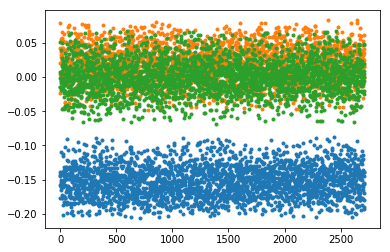

In [22]:
plot(tar, ls ='', marker = '.')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feat, 
                                                    tar, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers





b = 0
model = Sequential()
s = 8
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b), input_dim=X_train.shape[1]))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=3, activation='linear'))
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])



In [25]:
last_train = 1000
last_valid = 1000

for i in range(100):
    model.fit(X_train, y_train, epochs=500, batch_size= 500, verbose=0)
    train_loss = np.sqrt(model.evaluate(X_train, y_train, verbose = 0)[0])
    valid_loss = np.sqrt(model.evaluate(X_valid, y_valid, verbose = 0)[0])
    if train_loss < last_train and valid_loss > last_valid:
        break  #Early stopping
    else:
        last_train = train_loss
        last_valid = valid_loss
    print(train_loss, valid_loss)

0.023494440940112372 0.023095192775358108
0.020137470370694223 0.020156586593804288
0.019004120754097513 0.01942978821524416
0.017711478046409546 0.018081604260743015
0.01713343164752819 0.017687689551127896
0.01659443611424608 0.01705039498418393
0.016159978237435202 0.016717594432875762
0.016553637812614246 0.017191100908835154
0.016005267029901734 0.01664936652872768
0.01567942535049429 0.01629249940967655
0.015726139224865265 0.016417225861684
0.01607095017819226 0.016789274390647257
0.01547724040739215 0.016264780097660338
0.01584287038626415 0.016658257507436134
0.015109467983367673 0.015869591416491264
0.01518997589959578 0.015940027794533917
0.015088586063091276 0.015867767440222946
0.015136697113448614 0.015913348017343266
0.015242071336365485 0.015947396668196754
0.015323881344454377 0.016024705460848943
0.015138490933325473 0.015898037008257163
0.015336720406010872 0.01610260445690322
0.014916641392735725 0.015753386716445043
0.015172454746122816 0.016076696264249384
0.01513

In [26]:
rmd, _ = model.evaluate(X_test, y_test)
np.sqrt(rmd)

543/543 [==============================] - 0s 23us/step


0.01589487180929274

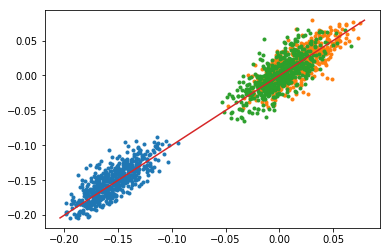

In [27]:
plot(model.predict(X_test), y_test, ls = '', marker = '.')
min_ = np.min(y_test)
max_ = np.max(y_test)
plot([min_, max_],[min_,max_])

In [28]:
model_name = '/elf/revpbe_to_pbe_mb_hexemb'

In [147]:
model.save('../../elf_models/models_masked/{}/force_{}'.format(model_name, which.upper()))

In [148]:
with open('../../elf_models/models_masked/{}/scaler_{}'.format(model_name, which.upper()), 'wb') as file:
    pickle.dump(scaler, file)

In [149]:
pd.DataFrame(feat_mask).to_csv('../../elf_models/models_masked/{}/mask_{}'.format(model_name, which.upper()), 
                               index = None, header = None)

In [29]:
# baseline = 'PBE_sz'
# reference = 'PBE_dz'

# which = 'h'
systems = ['monomers','dimers','trimers']
all_targets = []
all_features = []
# model = keras.models.load_model('../../elf_models/models_masked/{}/force_{}'.format(model_name, which.upper()))
# scaler = pickle.load(open('../../elf_models/models_masked/{}/scaler_{}'.format(model_name, which.upper()), 'rb'))
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_default_elf/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' + baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' + reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)
feat = feat[:,feat_mask]
feat = scaler.transform(feat)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


0.04203584682879513


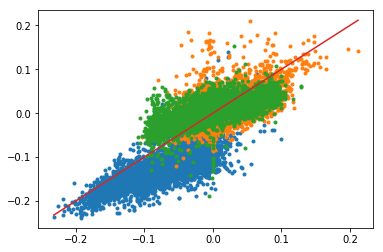

In [30]:
plot(targets, model.predict(feat),ls ='', marker = '.')
plot([np.min(targets), np.max(targets)],[np.min(targets),np.max(targets)])
print(np.sqrt(np.mean((targets -model.predict(feat))**2)))